### LOOP to FloPy - BADAMINNA

###### Kerry Bardot, Itsuo Camargo, Guillaume Pirot, Adam Siade, Jon-Philippe Pigois, Clive Hampton, James McCallum (2024)

This code uses a synthetic example to showcase the LOOP to FloPy workflow as follows:

1. Setup project 
2. Spatial data
3. Meshing
4. Geological model
5. Flow model discretisation (DIS inputs)
6. Flow model hydraulic properties (NPF inputs)
7. Flow model packages (IC, CHD, WEL, RCH, OBS inputs)


In [1]:
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_3952\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


### 1. Setup project 

In [2]:
P = Project('testproject', boundingbox = [340000, 40000, 6505000, 6550000, -1000, 0]) # (x0, x1, y0, y1, z0, z1)
P.crs = "epsg:28350" # Put in coordinate reference

### 2. Spatial data

#### Model boundary

In [3]:
#### ACTIVE MODEL AREA
model_boundary = gpd.read_file('../shp/model_boundary.shp')
model_boundary.to_crs(epsg=28350, inplace=True)
inner_boundary = model_boundary.buffer(-300)

model_boundary = resample_poly(model_boundary, 1500) 
inner_boundary = resample_poly(inner_boundary, 1500) 
type(model_boundary)

shapely.geometry.polygon.Polygon

#### Observation bores

In [4]:
#### OBS BORES
bore_df = pd.read_excel('../data/Dwer_data/Formation picks.xls', sheet_name = 'bore_info')
bore_gdf = gpd.GeoDataFrame(bore_df, geometry=gpd.points_from_xy(bore_df.Easting, bore_df.Northing), crs="epsg:28350")
obs_bores = gpd.clip(bore_gdf, model_boundary)
P.obsboreid = list(obs_bores.ID)
P.xyobsbores = list(zip(obs_bores.Easting, obs_bores.Northing))
type(obs_bores)

geopandas.geodataframe.GeoDataFrame

#### Pumping bores

In [5]:
### PUMPING BORES
P.xypumpbores = [(370000, 6515000), (365700, 6525000)] # # Fake pumping bores
P.pumpboreid = ['P1', 'P2']
P.xpumpbores, P.ypumpbores = list(zip(*P.xypumpbores))
pump_bores = gpd.GeoDataFrame(pd.DataFrame({'id': P.pumpboreid, 'x': P.xpumpbores, 'y': P.ypumpbores}), 
                       geometry=gpd.points_from_xy(x=P.xpumpbores, y=P.ypumpbores))
type(pump_bores)

geopandas.geodataframe.GeoDataFrame

#### Head boundary

In [6]:
#### HEAD BOUNDARIES
east_chd = gpd.read_file('../shp/east_chd.shp')
east_chd.to_crs(epsg=28350, inplace=True)
east_chd = gpd.clip(east_chd, model_boundary)
type(east_chd)

geopandas.geodataframe.GeoDataFrame

#### Fault

In [7]:
#### FAULT
P.fault_buffer = 800

# Create a shape file of Badaminna Fault
fx = [374540,374540,374000,374700,374750,373500,374000,374000]
fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
fault_trace = LineString(list(zip(fx, fy)))
fault_gdf = gpd.GeoDataFrame(geometry=[fault_trace], crs = P.crs)
fault_gdf.to_file('../shp/badaminna_trace.shp')

# Import fault shape file
bada_shp = gpd.read_file('../shp/badaminna_trace.shp')
bada_shp.to_crs(epsg=28350, inplace=True)
bada_shp = gpd.clip(bada_shp, model_boundary)

fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../shp/badaminna_trace.shp', model_boundary)

#### Plot of spatial inputs

Text(0.5, 1.0, 'Badaminna Model')

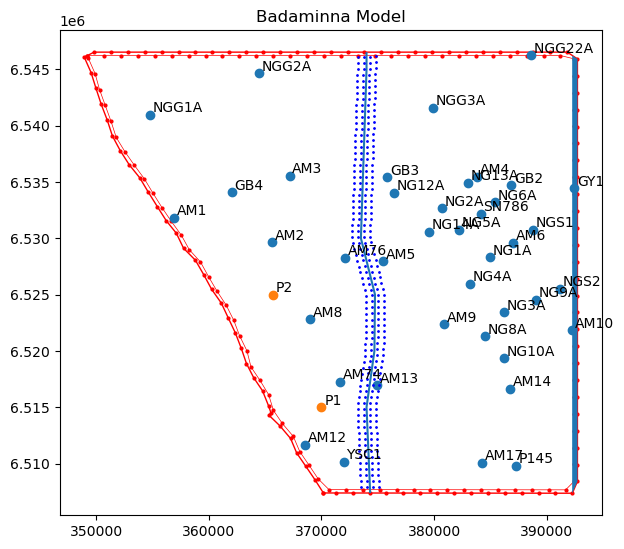

In [8]:
fig, ax = plt.subplots(figsize = (7,7))
x, y = model_boundary.exterior.xy
ax.plot(x, y, '-o', ms = 2, lw = 1, color='red')
x, y = inner_boundary.exterior.xy
ax.plot(x, y, '-o', ms = 2, lw = 0.5, color='red')

obs_bores.plot(ax=ax, zorder=2)
pump_bores.plot(ax=ax, zorder=2)
east_chd.plot(ax=ax, zorder=2)
bada_shp.plot(ax=ax, zorder=2)

for coord in fault_refinement_nodes:
    ax.plot(coord[0], coord[1], 'bo', ms = 1, zorder = 3) 

for x, y, label in zip(obs_bores.geometry.x, obs_bores.geometry.y, obs_bores.ID):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
for x, y, label in zip(pump_bores.geometry.x, pump_bores.geometry.y, pump_bores.id):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
ax.set_title('Badaminna Model')

### 3. Meshing 

#### Refinement criteria

In [9]:
P.workspace = '../modelfiles/'
P.triExeName = '../exe/triangle.exe'

P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.model_maxtri = 999999
P.angle = 32   # minimum triangle angles
P.radius1 = 500 # radius of inner circle around pumping bores
P.radius2 = 1000 # radius of outer circle around pumping bores
P.boremaxtri = 999999

#### Prepare polygons and nodes for meshing

In [10]:
# This function prepares refinement polygons around bores (bore coords are used as nodes)
def prepboremesh(P):
    
    theta = np.linspace(0, 2 * np.pi, 11)
    pump_bores_inner, pump_bores_outer = [], []
    obs_bores_inner, obs_bores_outer = [], []

    for i in P.xypumpbores:   
        X = i[0] + P.radius1 * np.cos(theta)
        Y = i[1] + P.radius1 * np.sin(theta)    
        vertices_inner = [(x_val, y_val) for x_val, y_val in zip(X, Y)]
        X = i[0] + P.radius2 * np.cos(theta)
        Y = i[1] + P.radius2 * np.sin(theta)    
        vertices_outer = [(x_val, y_val) for x_val, y_val in zip(X, Y)]
        pump_bores_inner.append(vertices_inner)
        pump_bores_outer.append(vertices_outer)

    return(pump_bores_inner, pump_bores_outer)


############ NODES = pump and obs bores, fault nodes (prepfaultmesh)
# For Voronoi Mesh, nodes include: pumping and observation bores, fault points

nodes = []

# BORES
for point in P.xypumpbores:
    nodes.append(point)
for point in P.xyobsbores:
    nodes.append(point)
    
# FAULT REFINEMENT POINTS
for point in fault_refinement_nodes: # Four lines of points
    nodes.append(point)
nodes = np.array(nodes)

############ POLYGONS
# For Voronoi Mesh, polygons include: model boundary, refinement polygons around pumping bores

polygons = [] # POLYGONS[(polygon, (x,y), maxtri)]

# MODEL BOUNDARY - Use shapely object for boundary
polygons.append((list(model_boundary.exterior.coords), 
                 (model_boundary.representative_point().x, model_boundary.representative_point().y), 
                  P.model_maxtri)) # Inside boundary frame

# PUMPING BORES - Use polygons generated from prepboremesh

boresinner, boresouter = prepboremesh(P)
for i in range(P.npump): # Append pumping bore zone polygons
    polygons.append((boresinner[i], P.xypumpbores[i], P.boremaxtri))
    polygons.append((boresouter[i],0, 0)) # 0, 0 means don't refine inside polygon

#### Create mesh arrays (cell2d, xcyc, vertices)

In [11]:
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor = vor_meshing(P, polygons, nodes)

#### Plot grid

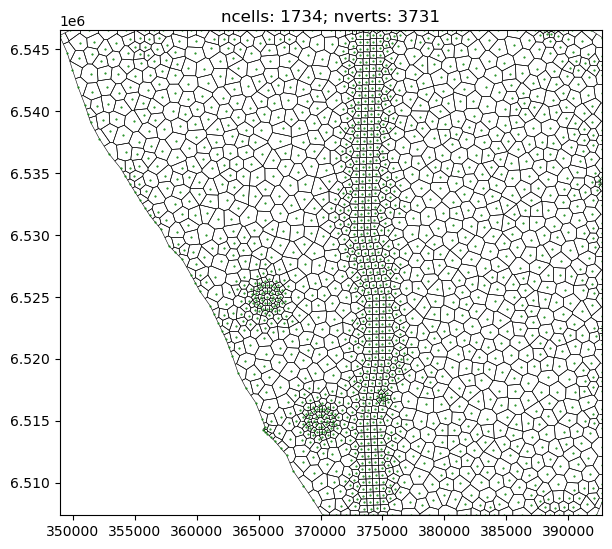

In [12]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(1, 1, 1, aspect='equal')
P.vor.plot(edgecolor='black', lw = 0.4)
for i in P.xcycvor: ax.plot(i[0], i[1], 'o', color = 'green', ms = 0.5)
for i in range(P.npump):
    ax.plot(P.xypumpbores[i], ms = 2, color = 'black')
#ax.set_xlim([368000,374000]) #([365000,380000])
#ax.set_ylim([P.y0, 6510000]) #([P.y0, 6520000])

### 4. Geological Model

<>:3: DeprecationWarning: invalid escape sequence \F
<>:20: DeprecationWarning: invalid escape sequence \F
<>:216: DeprecationWarning: invalid escape sequence \F
<>:242: DeprecationWarning: invalid escape sequence \F
C:\Users\19904604\AppData\Local\Temp\ipykernel_3952\3707312499.py:3: DeprecationWarning: invalid escape sequence \F
  "../data/Dwer_data\Formation picks.xls", sheet_name="bore_info"
C:\Users\19904604\AppData\Local\Temp\ipykernel_3952\3707312499.py:20: DeprecationWarning: invalid escape sequence \F
  "../data/Dwer_data\Formation picks.xls", sheet_name="strat_info"
C:\Users\19904604\AppData\Local\Temp\ipykernel_3952\3707312499.py:216: DeprecationWarning: invalid escape sequence \F
  "../data/Dwer_data\Formation picks.xls", sheet_name="Lleyland"
C:\Users\19904604\AppData\Local\Temp\ipykernel_3952\3707312499.py:242: DeprecationWarning: invalid escape sequence \F
  "../data/Dwer_data\Formation picks.xls", sheet_name="Other_constraints")
<>:3: DeprecationWarning: invalid escape 

[ 3.540e+05  6.488e+06 -1.200e+03] [4.070e+05 6.545e+06 3.000e+02]
['Ground', 'TQ', 'Tr', 'Tkm', 'Tk', 'Tkc', 'Kcl', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcomoo', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jc']


C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The

  0%|          | 0/20 [00:00<?, ?it/s]

ERROR: 2024-05-28 12:55:24,065: _geological_feature_builder.py:241 -- Not enough constraints for scalar field add more
ERROR: 2024-05-28 12:55:49,614: geological_model.py:1558 -- Model does not contain Parmelia
ERROR: 2024-05-28 12:55:49,614: geological_model.py:1558 -- Model does not contain Carnac
ERROR: 2024-05-28 13:00:20,137: geological_model.py:1558 -- Model does not contain Parmelia
ERROR: 2024-05-28 13:00:20,137: geological_model.py:1558 -- Model does not contain Carnac
ERROR: 2024-05-28 13:00:50,461: geological_model.py:1558 -- Model does not contain Parmelia
ERROR: 2024-05-28 13:00:50,470: geological_model.py:1558 -- Model does not contain Carnac
ERROR: 2024-05-28 13:01:20,473: geological_model.py:1558 -- Model does not contain Parmelia
ERROR: 2024-05-28 13:01:20,473: geological_model.py:1558 -- Model does not contain Carnac


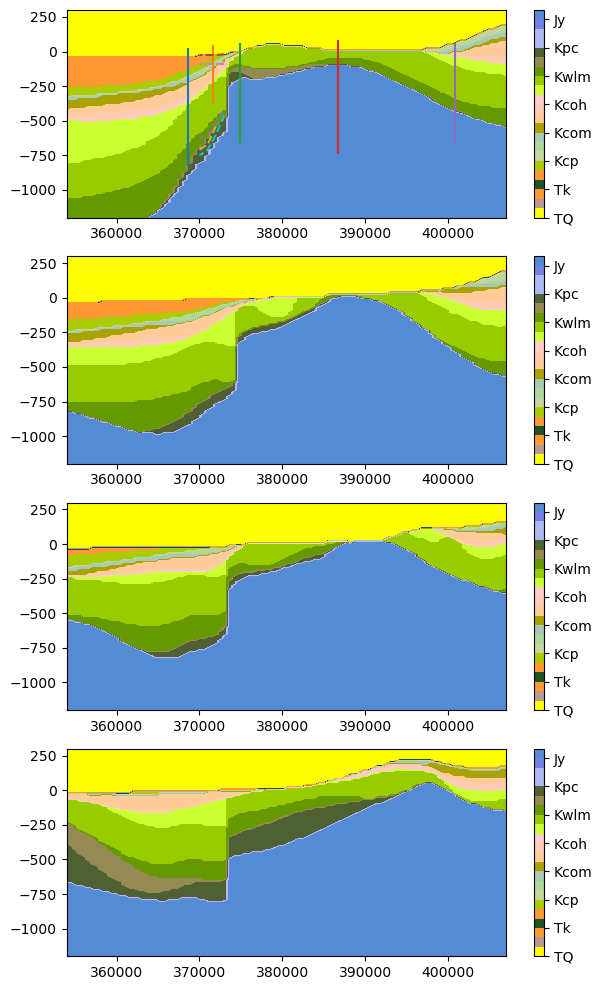

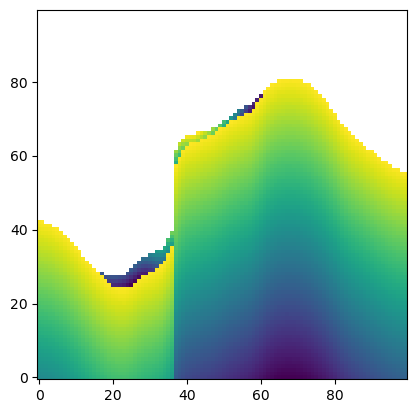

In [13]:
%run ./badaminna_geo.ipynb

In [15]:
#geomodel = GM(origin,maximum)
#fx = [374540,374541,374000,374700,374750,373500,374000,374001]
#fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
#dmax = 200.
#geomodel.add_fault(fx,fy,dmax)
#geomodel.make_geomodel()

In [21]:
Lmod.basedata

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,for_Kerry
0,NGG2A,364415.7,6544636.0,27.0,38.0,Ground,Quaternary,0.0,0.0,1.0,raw_data
1,NGG2A,364415.7,6544636.0,-8.0,-10.0,TQ,Quaternary,0.0,0.0,1.0,raw_data
2,NGG2A,364415.7,6544636.0,-8.0,0.0,NC1,NC1_FEAT,0.0,0.0,1.0,raw_data
3,NGG2A,364415.7,6544636.0,-45.0,-435.0,Kcl,Coolyena_1a,0.0,0.0,1.0,raw_data
4,NGG2A,364415.7,6544636.0,-45.0,0.0,NC2,NC2_FEAT,0.0,0.0,1.0,raw_data
...,...,...,...,...,...,...,...,...,...,...,...
51,GEO,368581.0,6511653.0,-1039,0.0,GEO,NC7_FEAT,0.0,0.0,1.0,Brett
52,GEO,375480.0,6527971.0,-246,-1109.0,GEO,Warbro,0.0,0.0,1.0,Brett
53,GEO,375480.0,6527971.0,-246,0.0,GEO,NC7_FEAT,0.0,0.0,1.0,Brett
54,GEO,362041.0,6534075.0,-638,-1109.0,GEO,Warbro,0.0,0.0,1.0,Brett


In [28]:
print(Lmod.basedata.for_Kerry.unique())

['raw_data' 'Brett']


In [32]:
def plot_bores(df):
    df = df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    i = 0
    for (xi, yi) in zip(df.X, df.Y):
        if df.lithcode[i] == 'Ground' and df.for_Kerry[i] == 'raw_data':
            plt.scatter(df.X[i], df.Y[i], color = 'blue')#, size = 2)
            plt.text(xi, yi, df.ID[i], size = 11, va='bottom', ha='center')
        if df.for_Kerry[i] == 'Brett':
            plt.scatter(df.X[i], df.Y[i], color = 'red')#, size = 2)
            plt.text(xi, yi, df.ID[i], size = 11, va='bottom', ha='center')
        i += 1
    plt.xlim(350000,380000)
    plt.ylim(6515000, 6530000)
    
plot_bores(Lmod.basedata)

In [ ]:
#dir(P.geomodel)
geomodel.geomodel.stratigraphic_ids()
geomodel.geomodel.feature_names()

In [ ]:
P.geomodel = geomodel.geomodel
print(P.geomodel.data.lithcode,'\n')
print(P.geomodel.stratigraphic_ids(),'\n')
print(P.geomodel.feature_names())


### 5. Flow model discretisation (DIS inputs)

In [ ]:
len(lithcodes)

In [ ]:
# ------------- FLOW MODEL PARAMETERS -----------------------#
P.nlv = 100  # number of layers for voxel transect grid
P.nlg = len(lithcodes)   # number of geological layers
P.nls = 2    # number of sublayers (per geological layer)
P.geo_pl = 7 # Which geological layer pumping from (zero-based)

M = Model('Bada_Flow_Model', P, plan = 'vor', transect = 'con') 
M.create_lith_dis_arrays(P)

In [ ]:
3909/60

### 6. Flow model hydraulic properties (NPF inputs)

In [ ]:
P.hk = [1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1, 10, 1]
P.vk = [i/1 for i in P.hk]
P.ss = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]

M.create_prop_arrays(P)
#for attribute, value in CV.__dict__.items(): print(attribute)

### 7. Flow model packages (IC, CHD, WEL, RCH, OBS, TDIS, OC inputs)

In [ ]:
# Set up ibd array to show special cells
gridprops = P.vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int) # 0-all, 1-wel, 2-obs, 3-chd
gi = flopy.utils.GridIntersect(vgrid)

#------------------------TDIS----------------------------
P.tdis_past = [(365, 12, 1.0)] # period length, number of timesteps, tsmult
P.tdis_future = [(5 * 365, 5 * 6, 1.0)] # period length, number of timesteps, tsmult

#------------------------RCH, IC----------------------------
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

In [ ]:
#------------------------WEL----------------------------
P.qwell_past = -100000 #m3/d 
P.qwell_future = -200000 #m3/d 

# Assume screening pumping well across entire geological layer
# Find top and bottom of screen 
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], M.xcyc)
    if P.geo_pl == 0:
        wel_top = M.top[wel_cell]  
    else:   
        wel_top = M.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = M.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print(wel_coords, wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))
    
#------------------------OBS----------------------------# Need to read in screened interval from bore_df
P.zobs = [-50, -100, -300, -500, -700, -900]
P.obs_points = []
for i in range(P.nobs):
    for z in P.zobs:
        P.obs_points.append((P.xyobsbores[i][0], P.xyobsbores[i][1], z))  

In [ ]:
for coords in P.xypumpbores:
    point = Point(coords)
    cells = gi.intersect(point)["cellids"]
    cells = np.array(list(cells))
    ibd[cells] = 1
        
for coords in P.xyobsbores:
    point = Point(coords)
    cells = gi.intersect(point)["cellids"]
    cells = np.array(list(cells))
    ibd[cells] = 2

In [ ]:
#------------------------CHD----------------------------
# identify cells on east_chd line
line = east_chd.geometry[0]
east_chd_cells = gi.intersect(line)["cellids"]
east_chd_cells = np.array(list(east_chd_cells))
ibd[east_chd_cells] = 3

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
pmv.plot_array(ibd, alpha = 0.6)
P.vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
M.create_flow_package_arrays(P) 
    
#dir(M)

### 8. Write and run flow model

In [ ]:
P.mfexe_name = '../exe/mf6.exe'

M.gwf, M.ss_head, M.ss_obs, M.run_time = M.write_run_model(P, period = 'Steady') 

In [ ]:
multiplot_prop_transect(P, models = [M], array = 'head_future', 
                        X0 = P.x0, Y0 = (P.y1-P.y0)/2, X1 = P.x1, Y1 = (P.y1-P.y0)/2,)
                        #vmin = -100, vmax = 500)

### BELOW HERE IS RUBBISH

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
CV.gwf.export('../figures/CV_vtk/US_model_results', fmt='vtk', smooth = False, vertical_exageration = 5., pvd = True)

In [ ]:
#CV.vtk_make(result = True, pfx = '_ss') 

In [ ]:
print_results()

#### Figures

In [ ]:
%run ./plotting_routines.ipynb

In [ ]:
nobs = len(obs_points)
fname = 'SU' + "_past.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=1)
data_frames = pd.DataFrame(data_set)
hobs = np.array(data_frames.values)
hobs = hobs[:,1:]
hobs = np.swapaxes(hobs, 0, 1)
hobs.shape

for ob in range(nobs):
    plt.plot(np.array(hobs[ob]))
    plt.ylabel('Head (m)')
    plt.legend(obs_points)

In [ ]:
multiplot_prop_transect(array = 'logk11', X0=x0, X1=x1, Y0=y0, Y1=y1)#, vmin = -10, vmax = 0) #vmin, vmax are optional

In [ ]:
multiplot_prop_transect(array = 'angle2', X0=x0, X1=x1, Y0=y0, Y1=y1)#, vmin = -4, vmax = 0)

In [ ]:
#multiplot_heads_plan(layer = 0, period = 'Past', obs_points= obs_points)#, vmin = 0, vmax = 100)

In [ ]:
multiplot_watertable(period = 'Past')

In [ ]:
multiplot_heads_transect(period = 'Past', X0=x0, X1=x1, Y0=y0, Y1=y1) # transect coords

In [ ]:
multiplot_prop_plan(P, array = 'angle1', layer = 50)

In [ ]:
multiplot_prop_plan(P, array = 'angle2', layer = 50)

In [ ]:
## EXPORT PARAVIEW
#UU.vtk_make(result = True, pfx = '_ss')   ????

In [ ]:
#SS.gwf.modelgrid.xyzcellcenters[2].shape  # list of 3: [nrow, ncol], [nrow, ncol], [nlay,nrow,ncol] 
#US.gwf.modelgrid.xyzcellcenters[2].shape  # list of 3: [ncell2d] [ncell2d] [nlay, ncell2d]
#SU.gwf.modelgrid.xyzcellcenters[2][0].shape  # list of 3: [ncell3d] [ncell3d] [1][ncell3d] 
#UU.gwf.modelgrid.xyzcellcenters[2][0].shape   # list of 3: [ncell3d] [ncell3d] [1][ncell3d] 


### Reference ("Truth")

In [ ]:
if run_reference:
    
    nrow, ncol, nlay = int(nrow_cg*1.5), int(nrow_cg*1.5), nlay_cg*2
    
    # Create geomodel and flow model
    REF = Model('REF', grid_plan = 'structured', grid_transect = 'structured')
    REF.LOOP2MF()
    REF.add_flow_packages()

    REF.gwf, REF.ss_head, REF.ss_obs, REF.run_ss = REF.write_run_model(workspace, period = 'Steady') 
    
    # Run past to get obs data
    REF.add_well(qwell_past)
    REF.gwf, REF.head_present, REF.obs_present, REF.run_past = REF.write_run_model(workspace, period = 'Past') 

    # Run future to generate reality of predictions
    REF.add_well(qwell_future)
    REF.gwf, REF.head_future, REF.obs_future, REF.run_future = REF.write_run_model(workspace, period = 'Future') 
    
    # CREATE SYNTHETIC OBSERVATIONS
    err = 0.3

    data_set = pd.read_csv('../modelfiles/REF_past.csv', header=1)
    data_frames = pd.DataFrame(data_set)
    ref_obs = np.array(data_frames.values)
    ref_obs = ref_obs[:,1::]
    ref_obs = np.swapaxes(ref_obs, 0, 1)
    nobs, nts = ref_obs.shape[0], ref_obs.shape[1]

    hobs_perturbed = np.copy(ref_obs)    
    for i in range(nobs):
        for j in range(nts): 
            hobs_perturbed[i][j] += np.random.normal(0.,err) # Perturb samples either side of measurement

    hobs_ref_past = [] # Sample every few time steps 
    for i in range(nobs):
        hobs_ref_past.append(hobs_perturbed[i][::4]) # Sample every 4 time steps

    ns = len(hobs_ref_past[0]) # number of samples in time
    print(len(hobs_ref_past[0]))
    print(len(hobs_perturbed[0][::4]))

    #Export reference as pickle file
    reference = [hobs_ref_past, REF.obs_present, REF.obs_future, REF.run_past, REF.run_future]
    pickle.dump(reference, open('../results/reference.pkl','wb'))
    reference_gwf = [REF.gwf]
    pickle.dump(reference, open('../results/reference.pkl','wb'))
    
# Load Reference Model
fname = '../results/reference.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
reference = pickle.load(pickleoff)
pickleoff.close()

hobs_ref_past = reference[0]
nobs = len(obs_points)
for i in range(nobs):
    plt.title('Observation data from the "TRUE" scenario')
    plt.plot(hobs_ref_past[i],'-o', ms = 5)
    plt.legend(np.linspace(0,nobs-1, nobs))

### MCMC

In [ ]:
%run ./modelling_routines.ipynb

#### Define statistics of parameters

In [ ]:
def Likelihood(obs,mod,err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))

from DREAM import *

Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(len(sim_hk)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(sim_hk[i]))
    Width.append(0.33) # SIGMA
    Min.append(np.log10(sim_hk[i])-1) 
    Max.append(np.log10(sim_hk[i])+1) 
    
for i in range(len(sim_vk)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(sim_vk[i]))
    Width.append(0.33)
    Min.append(np.log10(sim_vk[i])-1) 
    Max.append(np.log10(sim_vk[i])+1)
    
for i in range(len(sim_ss)):
    Unif.append(True)
    Log.append(True)
    Mean.append(np.log10(sim_ss[i]))
    Width.append(0.33)
    Min.append(np.log10(sim_ss[i])-1)
    Max.append(np.log10(sim_ss[i])+1)

In [ ]:
print(np.log10(sim_hk), np.log10(sim_vk), np.log10(sim_ss))

#### Set up DREAM and define "run model" function

In [ ]:
## DREAM for Steady State
err = 0.3
nchains = 5     #number of parrallel chains 
npars = len(Mean)  #number of parameters
nburn = 20
nsamples = 100

D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1  # Number of things to try each chain. Numbers other than 1 can give weird results for some models

#### Run first sample to get first likelihood

In [ ]:
modelname = 'UU' 
M = UU
#run_time_results = np.zeros((len(models), 3, nruns)) 

In [ ]:
if run_MCMC: 
    
    #h_mod_current = [] # list with 1 entry for each chain, that contains the last accepted parameters head result
    #h_pred_current = [] # list with 1 entry for each hhaon that saves the predicted heads.    
    
    for i in range(nchains):
        print('------------------------------------------------------')
        print("Chain = ", i)
        #hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss0, ss1, ss2, ss3
        np.set_printoptions(precision=3)
        
        print(D.chains[i].current[0],
                             D.chains[i].current[1],
                             D.chains[i].current[2],
                             D.chains[i].current[3],
                             D.chains[i].current[4],
                             D.chains[i].current[5],
                             D.chains[i].current[6],
                             D.chains[i].current[7],
                             D.chains[i].current[8],
                             D.chains[i].current[9],
                             D.chains[i].current[10],
                             D.chains[i].current[11],)
        
        hmod, run_time = model_make_n_run(D.chains[i].current[0],
                             D.chains[i].current[1],
                             D.chains[i].current[2],
                             D.chains[i].current[3],
                             D.chains[i].current[4],
                             D.chains[i].current[5],
                             D.chains[i].current[6],
                             D.chains[i].current[7],
                             D.chains[i].current[8],
                             D.chains[i].current[9],
                             D.chains[i].current[10],
                             D.chains[i].current[11],) 

        print('RUN TIME ', run_time)
        hmod = hmod[:,::4] # Resample observation data
        a = np.array(hobs_ref_past).flatten()
        b = np.array(hmod).flatten()
        print(a.shape, b.shape)
        D.chains[i].Lold = Likelihood(np.array(hobs_ref_past).flatten(), np.array(hmod).flatten(), err)

        plt.plot(np.array(hobs_ref_past).flatten(), 'o')
        plt.plot(np.array(hmod).flatten())
        plt.ylabel('Head (m)')
        plt.xlabel('')
        plt.legend()

#### Run all samples (LONG TIME TO RUN!)

In [ ]:
if run_MCMC: 
    fname = os.path.join(workspace, modelname + '_pars.dat')
    f = open(fname,'w')  #saves the pars  
    f.close()

    hobs_past_all, hobs_pred = [], [] # to save prediction results
    runtime_past_all = []
    for i in range(nsamples):
        for j in range(nchains):
            print("----------Sample = %i, Chain = %i----------" %(i, j))
            prop = D.propgenzs(D.chains[j].current,lookback = 10)
            Lnewdum = np.zeros(D.k)
            for k in range(D.k):
                print('range of m = ', D.k)
                print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
                hmod, run_time = model_make_n_run(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
                hmod = hmod[:,::4]
                a = np.array(hobs_ref_past).flatten()
                b = hmod.flatten()
                print(a.shape, b.shape)
                Lnewdum[k] = Likelihood(np.array(hobs_ref_past).flatten(), hmod.flatten(), err)
                #print(Lnewdum[k])
                #hk0, hk1, hk2, hk3, vk0, vk1, vk2, vk3, ss0, ss1, ss2, ss3
                print(prop[k,0],  prop[k,1],  prop[k,2],  prop[k,3],  prop[k,4],  prop[k,5],
                                     prop[k,6],  prop[k,7], prop[k,8], prop[k,9], prop[k,10], prop[k,11]) 
            L2dum = np.zeros_like(Lnewdum)
            kk = np.argmax(Lnewdum)
            prop2 = D.propgenzs(prop[kk,:],lookback = 10)
            prop2[-1,:] = D.chains[j].current
            L2dum[-1] = D.chains[j].Lold
            for m in range(D.k-1): 
                
                hmod, run_time = model_make_n_run(prop[m,0],  prop[m,1],  prop[m,2],  prop[m,3],  prop[m,4],  prop[m,5],
                                     prop[m,6],  prop[m,7], prop[m,8], prop[m,9], prop[m,10], prop[m,11])                                

                hmod = hmod[:,::4]

                L2dum[m] = Likelihood(np.array(hobs_ref_past).flatten(), hmod.flatten(), err)
                   
            tp = np.sum(Lnewdum)-np.sum(L2dum) # Transition Probability
            print('Last likelihood ' + str(D.chains[j].Lold) + 'Proposed likelihood', str(Lnewdum[kk]))
            if np.random.rand() < np.exp(tp): # If we accept parameters...

                D.chains[j].Lold = Lnewdum[kk]
                D.chains[j].current = prop[kk,:] 
                if i > nburn:                                      # If its past our burn period, we run a prediction...
                    print('\nAccepted! Saving parameters and runnning prediction...')
                    hobs_past_all.append(hmod)           # We wants to save head and look at later....
                    runtime_past_all.append(run_time)    # We wants to save the runtime
                    hpred = run_prediction(M, prop[kk,:])           # RUN PREDICTION
                    hobs_pred.append(hpred)                         # Save the prediction
            D.chains[j].pars = np.vstack((D.chains[j].pars,D.chains[j].current))
            D.chains[j].likelihood = np.append(D.chains[j].likelihood,D.chains[j].Lold)
        
        D.gen_mod()
        #print(D.rate)
        fname = os.path.join(workspace, modelname + '_pars.dat')
        f = open(fname,'a')
        for i in range(nchains):
            f.write('%g ' % D.chains[i].Lold)
            for j in range(npars):
                f.write('%g ' %  D.chains[i].current[j])
            f.write('\n')
        f.close()
        
    for i in range(nchains): # For each chain
        plt.plot(D.chains[i].likelihood)#, 'o', ms = 2)

    plt.ylabel('ln(Likelihood)')
    plt.xlabel('Samples')

    plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
    plt.axvline(nburn)
    plt.text(nburn - 40,-200,'Burn in') 
    plt.text(nburn + 5,-200,'Sampling')
      
    fname = '../results/' + modelname + '_hobs_past.pkl'
    pickle.dump(hobs_past_all, open(os.path.join(workspace, fname),'wb'))
    
    fname = '../results/' +  modelname + '_hobs_pred.pkl' # Pickle the future
    pickle.dump(hobs_pred, open(os.path.join(workspace, fname),'wb'))

In [ ]:
UU.botm[2,:]

In [ ]:
%run ./plotting_routines.ipynb
plot_problem_cell('UU', 8609)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(workspace, modelname + '_pars.dat')
B = np.loadtxt(fname)[nburn*nchains:,1:]
print(B.shape) #750, 12
A = B.reshape((nsamples-nburn, nchains, npars))


In [ ]:
colors = ['b','c','r','g', 'y']
for i in range(npars):
    plt.plot(B[:,i], 'o',ms=1)
plt.legend(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3', 'ss0', 'ss1', 'ss2', 'ss3'])
plt.xlabel('samples x chains')
plt.ylabel('value (log K)')

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))
    
fig, ax = plt.subplots(1,1, figsize = (6,4))
for i in range(nsamples*nchains - nburn*nchains): 
    for j in range(npars):
        ax.plot(j, B[i,j],'o', ms = 2.)

for j in range(npars):
    ax.plot(j,Mean[j], 'o', ms = 5., color = 'black')
ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,12,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3', 'ss0', 'ss1', 'ss2', 'ss3'])
ax.set_ylabel('Log Value')

### Compare predicted vs truth (PAST)

In [ ]:
# Load REALITY past
fname = "REF_past.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
times_past = times_past[::4] # resample every 4

reality_past = np.array(df.values) # turn df to array
reality_past = reality_past[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_past = reality_past[::4] # sample period every 4
reality_past = np.swapaxes(reality_past, 0, 1) # better to have obs as axis 0
print('reality past shape ', reality_past.shape) # 9 obs, 6 times

# Load REALITY past
fname = "REF_future.csv"
csv_file = os.path.join(workspace, fname)
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365
times_future = times_future[::4] # resample every 4

reality_future = np.array(df.values) # turn df to array
reality_future = reality_future[:,1:nobs+1] # get rid of left column of times and nan columns on right
reality_future = reality_future[::4] # sample period every 4
reality_future = np.swapaxes(reality_future, 0, 1) # better to have obs as axis 0
print('reality future shape ', reality_future.shape) # 9 obs, 6 times

In [ ]:
# Load PAST HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_past.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_past = pickle.load(pickleoff)
pickleoff.close()
obs_past = np.array(obs_past)
print('obs_past shape ', obs_past.shape) #(445, 9, 6)

# Load PREDICTED HEADS AT OBS POINTS
fname = '../results/' + modelname + '_hobs_pred.pkl'
pickleoff = open(os.path.join(workspace, fname),'rb')
obs_future = pickle.load(pickleoff)
pickleoff.close()
obs_future = np.array(obs_future)
obs_future = obs_future[:,:,::4]
print('obs_future shape', obs_future.shape) #(290, 9, 29)

### Plot reality vs past and predicted

In [ ]:
len(obs_past)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3),3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    # PLOT PAST
    for i in range(len(obs_past)):
        ax.plot(times_past, obs_past[i][n], 'o', ms = 2 ) 
    ax.plot(times_past, reality_past[n], lw = 2, color = 'black') # Plot truth
    
    # PLOT FUTURE
    for i in range(len(obs_future)):
        ax.plot(times_future + 2, obs_future[i][n], 'o', ms = 2 ) 
    ax.plot(times_future + 2, reality_future[n], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): 
        ax.set_xlabel('Time (years)', size = 10)
        ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2)
    #ax.set_ylim([0,80])
    

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.suptitle(modelname, size = 14)

for n in range(nobs):   
    ax = plt.subplot(int(nobs/3), 3,n+1,aspect='auto')
    ax.set_title('Obs %i' %(n))
    
    ax.hist(obs_future[:,n,-1], bins = 15)
    ax.axvline(reality_future[n, -1], lw = 2, color = 'black') # Plot truth

    if n > (nobs-4): ax.set_xlabel('Predicted head (m)', size = 10)
    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Frequency', size = 10)
    ax.set_xlim([reality_future[n, -1] - 10, reality_future[n, -1] + 10])
    #ax.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[0, 1, 2, 3, 4, 5, 6, 7],size = 10)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
def resample_polygon_edge(polygon, distance):
    """
    Resample points along the edge of a Polygon.
    
    Parameters:
        polygon (Polygon): The Polygon geometry to resample.
        distance (float): The distance between each point.
    
    Returns:
        list: A list of Point geometries sampled at specified distances along the polygon's edge.
    """
    exterior_coords = list(polygon.exterior.coords)
    exterior_line = LineString(exterior_coords)
    resampled_line = []
    current_distance = 0
    while current_distance <= exterior_line.length:
        resampled_line.append(exterior_line.interpolate(current_distance))
        current_distance += distance
    return resampled_line

def get_ls_from_gdf(gdf):
    points = []
    for line in gdf['geometry']:
        x, y = line.xy
        points.extend(list(zip(x, y)))
    ls = LineString(points)
    return(ls)

def get_xy_from_gdf(gdf):
    points = []
    for line in gdf['geometry']:
        x, y = line.xy
        points.extend(list(zip(x, y)))
    x,y = zip(*points)
    return(x,y)

In [ ]:
#Define a function that returns a list of X,Y
def extract_coord_from_shape(gdf):
    coordinates = []
    for geometry in gdf.geometry:
        if geometry.geom_type == 'Polygon': # For polygons, extract X and Y coordinates
            coords = geometry.exterior.coords
            for x, y in coords:
                coordinates.append([x,y])
        elif geometry.geom_type == 'LineString': # For linestrings, extract X and Y coordinates
            coords = geometry.coords
            for x, y in coords:
                coordinates.append([x,y])    
    return coordinates